In [5]:
import numpy as np
import jax.numpy as jnp
import dill
from igm_emulator.emulator.emulator_run import nn_emulator
import matplotlib.pyplot as plt
import h5py
import IPython
import sys
import os
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/hmc')
from nn_hmc_3d_x import NN_HMC_X

In [4]:
true_temp_idx = 11
true_gamma_idx = 4
true_fobs_idx = 7
n_inference = 5
# read in Molly's nearest grid models
zstr = 'z54'
skewers_per_data = 17
n_covar = 500000
bin_label = '_set_bins_4'
in_path_molly = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{zstr}/final_135/'
# get initial grid
in_name_h5py = f'correlation_temp_fluct_skewers_2000_R_30000_nf_9_dict{bin_label}.hdf5'
with h5py.File(in_path_molly + in_name_h5py, 'r') as f:
    params = dict(f['params'].attrs.items())
fobs = params['average_observed_flux']
R_value = params['R']
v_bins = params['v_bins']
t_0s = 10.**params['logT_0']
gammas = params['gamma']
n_temps = len(t_0s)
n_gammas = len(gammas)
n_f = len(fobs)

noise_idx = 0
like_name_0 = f'likelihood_dicts_R_30000_nf_9_T{true_temp_idx}_G{true_gamma_idx}_SNR0_F{true_fobs_idx}_ncovar_500000_P{skewers_per_data}_set_bins_4.p'
like_dict_0 = dill.load(open(in_path_molly + like_name_0, 'rb'))
in_name_new_params = f'new_covariances_dict_R_30000_nf_9_ncovar_{n_covar}_' \
                     f'P{skewers_per_data}{bin_label}_params.p'
new_param_dict = dill.load(open(in_path_molly + in_name_new_params, 'rb'))
new_temps = new_param_dict['new_temps']
new_gammas = new_param_dict['new_gammas']
new_fobs = new_param_dict['new_fobs']
n_new_t = (len(new_temps) - 1)/(len(t_0s) - 1) - 1
n_new_g = (len(new_gammas) - 1)/(len(gammas) - 1) - 1
n_new_f = (len(new_fobs) - 1)/(len(fobs) - 1) - 1
new_models_np = np.empty([len(new_temps), len(new_gammas), len(new_fobs), len(v_bins)])

for old_t_below_idx in range(n_temps - 1):
    print(f'{old_t_below_idx / (n_temps - 1) * 100}%')
    for old_g_below_idx in range(n_gammas - 1):
        for old_f_below_idx in range(n_f - 1):
            fine_dict_in_name = f'new_covariances_dict_R_{int(R_value)}_nf_{n_f}_T{old_t_below_idx}_' \
                                f'G{old_g_below_idx}_SNR0_F{old_f_below_idx}_ncovar_{n_covar}_' \
                                f'P{skewers_per_data}{bin_label}.p'
            fine_dict = dill.load(open(in_path_molly + fine_dict_in_name, 'rb'))
            new_temps_small = fine_dict['new_temps']
            new_gammas_small = fine_dict['new_gammas']
            new_fobs_small = fine_dict['new_fobs']
            new_models_small = fine_dict['new_models']
            new_covariances_small = fine_dict['new_covariances']
            new_log_dets_small = fine_dict['new_log_dets']
            if old_t_below_idx == n_temps - 2:
                added_t_range = n_new_t + 2
            else:
                added_t_range = n_new_t + 1
            if old_g_below_idx == n_gammas - 2:
                added_g_range = n_new_g + 2
            else:
                added_g_range = n_new_g + 1
            if old_f_below_idx == n_f - 2:
                added_f_range = n_new_f + 2
            else:
                added_f_range = n_new_f + 1
            # print(added_f_range)
            for added_t_idx in range(int(added_t_range)):
                for added_g_idx in range(int(added_g_range)):
                    for added_f_idx in range(int(added_f_range)):
                        final_t_idx = int((old_t_below_idx * (n_new_t + 1)) + added_t_idx)
                        final_g_idx = int((old_g_below_idx * (n_new_g + 1)) + added_g_idx)
                        final_f_idx = int((old_f_below_idx * (n_new_f + 1)) + added_f_idx)
                        new_models_np[final_t_idx, final_g_idx, final_f_idx, :] = new_models_small[added_t_idx, added_g_idx, added_f_idx, :]
new_models = jnp.array(new_models_np)

0.0%
7.142857142857142%
14.285714285714285%
21.428571428571427%
28.57142857142857%
35.714285714285715%
42.857142857142854%
50.0%
57.14285714285714%
64.28571428571429%
71.42857142857143%
78.57142857142857%
85.71428571428571%
92.85714285714286%


In [7]:
def return_idx(value, all_values):
    the_min_value = jnp.min(all_values)
    the_range = jnp.max(all_values) - the_min_value
    scaled_value = (value - the_min_value) / the_range * (len(all_values) - 1)
    nearest_idx = int(jnp.round(scaled_value))
    return nearest_idx
def get_molly_model_nearest(theta,
                                  fine_temps=new_temps, fine_gammas=new_gammas, fine_fobs=new_fobs,
                                  fine_models=new_models):
    temp, gamma, ave_f = theta
    temp_idx = return_idx(temp, fine_temps)
    gamma_idx = return_idx(gamma, fine_gammas)
    fobs_idx = return_idx(ave_f, fine_fobs)
    model = fine_models[temp_idx, gamma_idx, fobs_idx, :]
    return model
def log_likelihood_molly(theta, corr, theta_covariance=like_dict_0['covariance']
                         , true_log_det=like_dict_0['log_determinant']):
    # temp, g, ave_f = theta
    model = get_molly_model_nearest(theta)
    diff = corr - model
    nbins = len(corr)
    log_like = -(jnp.dot(diff, jnp.linalg.solve(theta_covariance, diff)) + true_log_det + nbins * jnp.log(2.0 * jnp.pi)) / 2.0
    return log_like

run_tag = f'data_nearest_model{bin_label}'
prior_tag = f'one_prior_T{true_temp_idx}_G{true_gamma_idx}_F{true_fobs_idx}'
out_file_tag = f'log_like_on_grid_{int(n_inference)}_{prior_tag}_R_{int(R_value)}_one_covariance'
in_name_inference = f'{zstr}_{run_tag}_{out_file_tag}.hdf5'
print('reading in')
with h5py.File(in_path_molly + in_name_inference, 'r') as f:
    # IPython.embed()
    true_theta = f['true_theta'][:, :]
    temps_grid = f['temps_grid'][:]
    gammas_grid = f['gammas_grid'][:]
    fobs_grid = f['fobs_grid'][:]
    molly_log_likelihood_grid = f['log_likelihood_grid'][:, :, :, :]  # mocks (5), t_0s (57), gammas (33), <F> (33)

reading in


In [10]:
# get Linda's model
in_path_linda = '/mnt/quasar2/zhenyujin/igm_emulator/emulator/best_params/'
emu_name = f'{zstr}_best_param_training_768.p'
best_params = dill.load(open(in_path_linda + emu_name, 'rb'))
nn_x = NN_HMC_X(v_bins, best_params, t_0s, gammas, fobs, like_dict_0)
linda_loglike_grid = dill.load(open(f'linda_loglike_grid_{emu_name}.p', 'rb'))

def get_linda_model(theta, best_params_function=best_params):
    theta_linda = (theta[2], theta[0], theta[1])
    model = nn_emulator(best_params_function, theta_linda)
    return model

def log_likelihood_linda(theta, corr):
    theta_linda = (theta[2], theta[0], theta[1])
    ll_linda = nn_x.log_likelihood(theta_linda, corr)
    return ll_linda

# read in the mock data
mock_name = f'mocks_R_{int(R_value)}_nf_{n_f}_T{true_temp_idx}_G{true_gamma_idx}_SNR{noise_idx}_F{true_fobs_idx}_P{skewers_per_data}{bin_label}.p'
mocks = dill.load(open(in_path_molly + mock_name, 'rb'))

In [39]:
print(like_dict_0['covariance'],like_dict_0['log_determinant'])
print()

-5113.026959073321


In [24]:
print(linda_loglike_grid.shape)
print(linda_loglike_grid[1,16,:,16])

(5, 33, 57, 33)
[2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215 2153.39510215 2153.39510215 2153.39510215
 2153.39510215 2153.39510215]


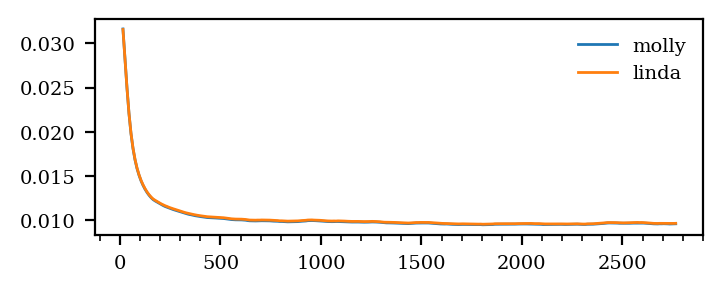

In [12]:
x_size = 3.5
dpi_value = 200
plt_params = {'legend.fontsize': 7,
              'legend.frameon': False,
              'axes.labelsize': 8,
              'axes.titlesize': 6.5,
              'figure.titlesize': 8,
              'xtick.labelsize': 7,
              'ytick.labelsize': 7,
              'lines.linewidth': 1,
              'lines.markersize': 2,
              'errorbar.capsize': 3,
              'font.family': 'serif',
              # 'text.usetex': True,
              'xtick.minor.visible': True,
              }
plt.rcParams.update(plt_params)
# plot one example of model comparison
temperature_want = 10000.
theta_want = (temperature_want, gammas[true_gamma_idx], fobs[true_fobs_idx])
model_molly = get_molly_model_nearest(theta_want)
model_linda = get_linda_model(theta_want)

model_fig = plt.figure(figsize=(x_size, x_size*.77*.5), constrained_layout=True,
                                dpi=dpi_value,
                                )
# one_correlation_fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
grid = model_fig.add_gridspec(
    nrows=1, ncols=1, # width_ratios=[20, 20, 20, 20, 20, 1],
)
axes = model_fig.add_subplot(grid[0])
axes.plot(v_bins, model_molly, label='molly')
axes.plot(v_bins, model_linda, label='linda')
axes.legend()
plt.show()

In [43]:
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/scripts')
from grab_models import *

n_samples = 100
samples = lhs(3, samples=n_samples)

final_samples = np.empty([n_samples, 3])
for sample_idx, sample in enumerate(samples):
    # convert the output of lhs (between 0 and 1 for each parameter) to our model grid
    sample_params = param_transform(sample,
                                    np.array([temps_grid[0], gammas_grid[0], fobs_grid[0]]),
                                    np.array([temps_grid[-1], gammas_grid[-1], fobs_grid[-1]]))
    final_samples[sample_idx, :] = sample_params

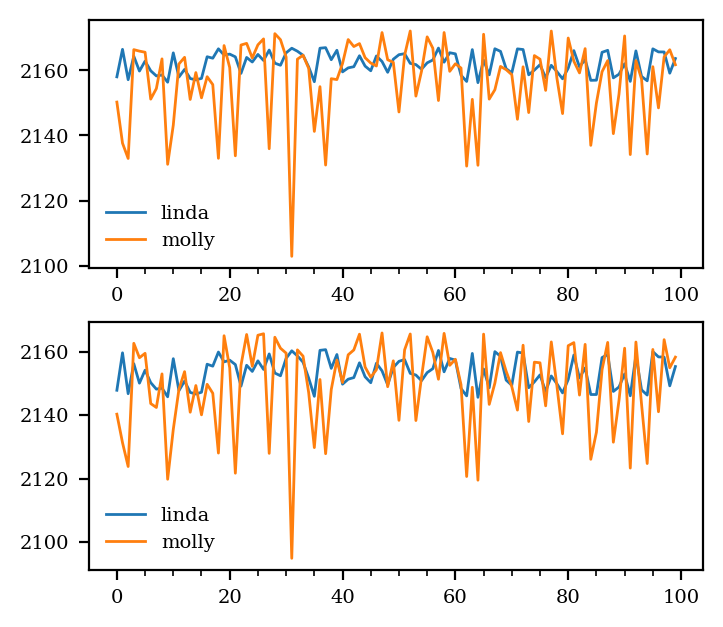

In [45]:
likelihood_fig = plt.figure(figsize=(x_size, x_size*.77*5.*.5), constrained_layout=True,
                                dpi=dpi_value,
                                )
# one_correlation_fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
grid = likelihood_fig.add_gridspec(
    nrows=5, ncols=1, # width_ratios=[20, 20, 20, 20, 20, 1],
)   
for mock_idx in range(2):
    axes = likelihood_fig.add_subplot(grid[mock_idx])
    linda = np.empty(n_samples)
    molly = np.empty(n_samples)
    for sample_idx, sample in enumerate(final_samples):
        linda[sample_idx] = log_likelihood_linda(sample,mocks[mock_idx]) 
        molly[sample_idx] = log_likelihood_molly(sample,mocks[mock_idx]) 
        
    axes.plot(np.arange(n_samples),linda,label ='linda')#blue
    axes.plot(np.arange(n_samples),molly, label = 'molly')#orange
    axes.legend()

[2.16009841e+003 2.16648605e+003 2.16349817e+003 2.16593528e+003
 2.15783238e+003 2.16682045e+003 2.15660112e+003 2.15881464e+003
 2.16063768e+003 4.44659081e-323 4.94065646e-323 5.43472210e-323
 5.92878775e-323 6.42285340e-323 6.91691904e-323 7.41098469e-323
 7.90505033e-323 8.39911598e-323 8.89318163e-323 9.38724727e-323
 9.88131292e-323 1.03753786e-322 1.08694442e-322 1.13635099e-322
 1.18575755e-322 1.23516411e-322 1.28457068e-322 1.33397724e-322
 1.38338381e-322 1.43279037e-322 1.48219694e-322 1.53160350e-322
 1.58101007e-322 1.63041663e-322 1.67982320e-322 1.72922976e-322
 1.77863633e-322 1.82804289e-322 1.87744945e-322 1.92685602e-322
 1.97626258e-322 2.02566915e-322 2.07507571e-322 2.12448228e-322
 2.17388884e-322 2.22329541e-322 2.27270197e-322 2.32210854e-322
 2.37151510e-322 2.42092166e-322 2.47032823e-322 2.51973479e-322
 2.56914136e-322 2.61854792e-322 2.66795449e-322 2.71736105e-322
 2.76676762e-322 2.81617418e-322 2.86558075e-322 2.91498731e-322
 2.96439388e-322 3.013800

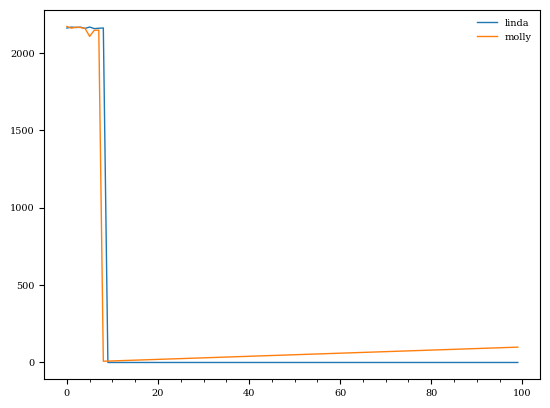

In [40]:
print(linda,molly)
plt.plot(np.arange(n_samples),linda,label ='linda')#blue
plt.plot(np.arange(n_samples),molly, label = 'molly')#orange
plt.legend()
plt.show()

In [50]:
molly_name = f'z54_data_nearest_model_set_bins_4_steps_48000_mcmc_inference_5_one_prior_T{true_temp_idx}_G{true_gamma_idx}_F{true_fobs_idx}_R_30000.hdf5'
molly_model = h5py.File(in_path_molly + molly_name, 'r')

molly_sample = molly_model['samples'][mock_idx, :, :]
molly_flip = np.zeros(shape=molly_sample.shape)
molly_flip[:, 0] = molly_sample[:, 2]
molly_flip[:, 1] = molly_sample[:, 0]
molly_flip[:, 2] = molly_sample[:, 1]

t_molly, g_molly, f_molly = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                zip(*np.percentile(molly_sample, [16, 50, 84], axis=0)))

print(log_likelihood_molly(theta=[t_molly[0], g_molly[0], f_molly[0]],corr= mocks[0]))
print(log_likelihood_linda(theta=[t_molly[0], g_molly[0], f_molly[0]],corr= mocks[0]))

2170.9685974482945
2163.1873178782416


Text(0.5, 0, '$T_0$ (K)')

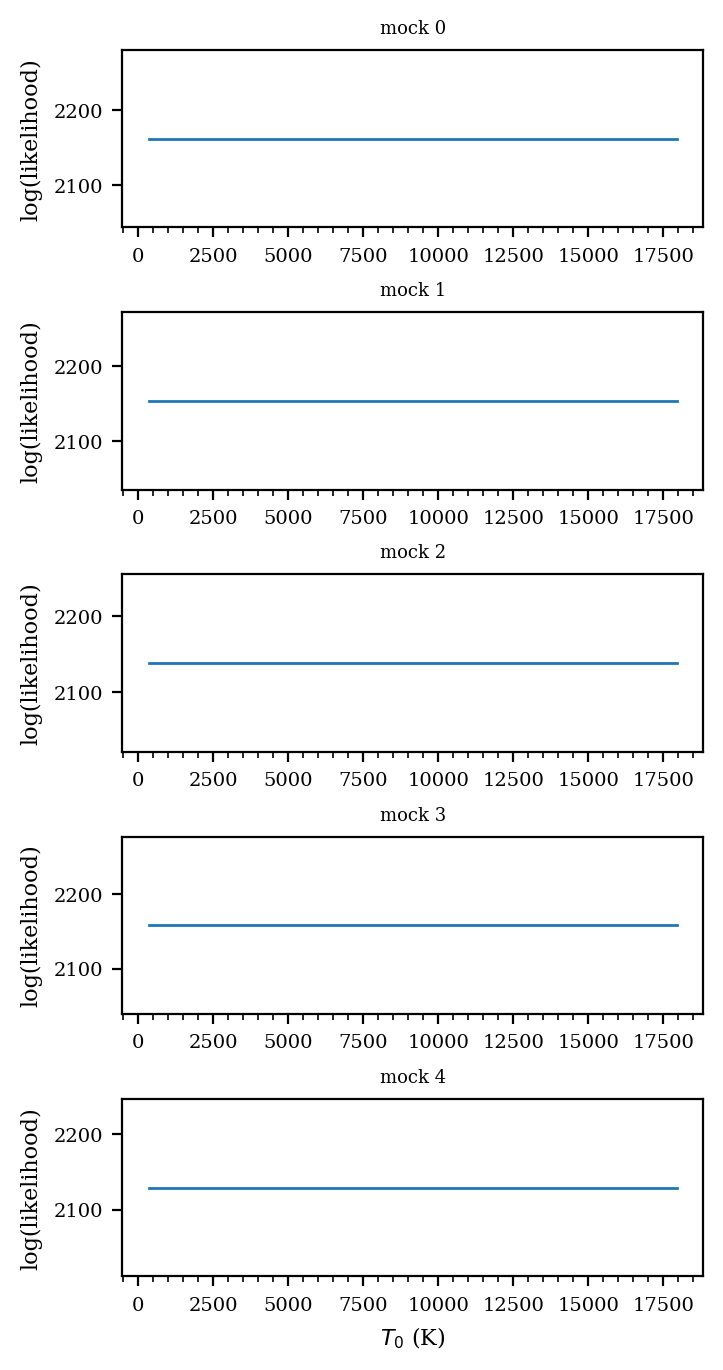

In [26]:
# plot one 1d slice of likelihood - temps only
g_plot_idx = int(np.floor(len(gammas_grid)/2.))
f_plot_idx = int(np.floor(len(fobs_grid)/2.))
# IPython.embed()
likelihood_fig = plt.figure(figsize=(x_size, x_size*.77*5.*.5), constrained_layout=True,
                                dpi=dpi_value,
                                )
# one_correlation_fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
grid = likelihood_fig.add_gridspec(
    nrows=5, ncols=1, # width_ratios=[20, 20, 20, 20, 20, 1],
)

for mock_idx in range(n_inference):
    axes = likelihood_fig.add_subplot(grid[mock_idx])
    axes.plot(temps_grid, linda_loglike_grid[mock_idx, f_plot_idx, :, g_plot_idx])
    axes.set_ylabel('log(likelihood)')
    axes.set_title(f'mock {mock_idx}')
axes.set_xlabel('$T_0$ (K)')